# Exploring Autoencoders with FashionMNIST

Autoencoders are a simple yet elegant example of a feed-forward neural network.  A generic autoencoder consists of three major components: the encoder, the code, and the decoder.  The encoder is a simple multilayer perceptron that takes a high-dimensional input and outputs something low-dimensional.  This low-dimensional output is called the code (or sometimes the latent space representation).  Therefore, in a similar vein as PCA, the job of the encoder is to produce a compressed, low-dimensional representation of the input.  The decoder performs the opposite operation.  It takes the code, "interprets" it, and outputs an image.  Informally, we judge an autoencoder to be performing well if the output image "closely" matches the input image.  This may indicate that the code produced by the network for each image adequately captures the essential properties of the image.

However, as described so far, this is all incredibly vague.  What does it mean to say that two images are "close?"  More importantly, what really is this code that is produced by the autoencoder, and how can we determine quantitatively whether it "captures" the important aspects of an image?  Answering these questions will be the central focus of this part of the report.

In view of this objective, there are other considerations that I would like to take into account.  We know that fully-connected layers tend to require regularization.  They also often suffer from overfitting.  Since generic autoencoders consist entirely of such layers, regularizing the network and protecting against overfitting can be crucial.  Therefore, I will be considering two methods to deal with these issues.  First, I will explore the effects of adding Gaussian noise to the input image during training.  In theory, this should help with overfitting, as the network is now forced during training to reconstruct the original image (without noise) without ever actually seeing it.  Second, I will explore the effects of adding L2 regularization to the fully-connected layers.  This is accomplished in pytorch by adding weight decay to the optimizer.  This should help to regularize the network, as the L2 penalty forces the network to utilize all of the nodes in the network.

I also wish to explore stacked autoencoders.  As the name suggests, a stacked autoencoder consists of generic autoencoders stacked on top of one another (the output of one autoencoder is the input into the next).  In theory, making the network deeper should allow for finer-grained properties of the images to be extracted.  However, the risk is that adding more fully-connected layers will make the network overfit.  Therefore, employing the strategies described in the previous paragraph will be important.

The dataset with which I will be working is the FashionMNIST dataset.  This is a simple dataset consisting of 28x28 grayscale images of 10 different categories of clothing.  There are 60,000 training/validation examples and 10,000 testing examples.

The objectives of this report are:
+ Perform PCA on the FashionMNIST dataset - This will act as a baseline for the rest of the report
+ Train 8 autoencoders on FashionMNIST.  Each network will take one value for each of the following hyperparameters:  noise = [True, False], weight decay = [1e-5, 0], stacks = [1, 2].
+ Compute metrics on the codes of each network and compare to PCA
+ Train a logistic classifier on the codes and compare to PCA

## Importing Data and Libraries

In [1]:
#Importing Libraries

import os
import csv
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from skimage.util import random_noise
from sklearn.decomposition import PCA



In [2]:
# If using google colab, then you must run this cell to enable the matplotlib 
# Widget.  We will need these widgets to plot the PCAs and codes from the 
# Autoencoder

from google.colab import output
output.enable_custom_widget_manager()

In [3]:
# You may need to install this to run the matplotlib widgets

!pip install ipympl

     |████████████████████████████████| 507 kB 25.5 MB/s 


In [4]:
#Importing FashionMNIST and splitting into train, val, test datasets

train_data, val_data = random_split(datasets.FashionMNIST(root='./data', train=True, download=True,
                                                   transform=transforms.ToTensor()), [55000, 5000])
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
#Setting batch size and constructing dataloaders

BATCH_SIZE=128

train_dl = DataLoader(train_data, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_data, BATCH_SIZE, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_data, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [215]:
#This dictionary converts interger labels to actual label names

labels_dict = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

## PCA

As discussed in the introduction, an autoencoder can be thought of as a dimension-reduction technique, as the encoder encodes high-dimensional data in a low-dimensional vector.  Naturally, it makes sense to compare the codes of an autoencoder to the principal components of PCA as PCA is the classical technique for dimension reduction.  I will be looking at the first 3 components (and below the codes of the autoencoder are of dimension 3).  One reason for this is that it allows the plotting of the components in 3D.

In [217]:
# In this cell, we gather the test images and labels

test_images = []
pca_labels = []

for batch in test_dl:
    images, label = batch
    #Turning image into vector
    images = images.view(images.size(0), -1)
    test_images.append(images)
    pca_labels.append(label)

#Concatenating all images into tensor
test_images = torch.cat(test_images, dim=0)
#Converting to numpy array
test_images = test_images.numpy().transpose()
#Gathering all labels into single tensor and converting to list
pca_labels = torch.cat(pca_labels, dim=0)
pca_labels = pca_labels.tolist()
#Getting actual label names
labels_names = [labels_dict[i] for i in pca_labels]

#Storing labels as df
df_labels = pd.DataFrame(data=labels_names, columns=['Labels'])

In [218]:
#Running basic PCA and getting first 3 pc's
pca = PCA(n_components=3)
pca.fit(test_images)
components = pca.components_.transpose()
#Normalizing components
components = (components - np.mean(components)) / np.std(components)

#Storing normalized components and labels in df
pca_df = pd.DataFrame(data=components, columns=['pc1', 'pc2', 'pc3'])
pca_df = pd.concat([pca_df, df_labels['Labels']], axis=1)

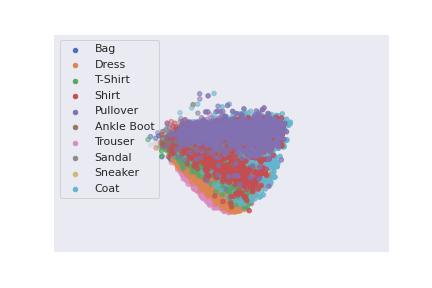

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [220]:
#Plotting the pc's

%matplotlib widget

sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for s in pca_df.Labels.unique():
    ax.scatter(pca_df.pc1[pca_df.Labels==s],
               pca_df.pc2[pca_df.Labels==s], 
               pca_df.pc3[pca_df.Labels==s], label=s)
    ax.axis('Off')

plt.legend()
plt.show()

Above is a 3D scatter plot of the first three principal components of the test data.  Of course, it is difficult to glimpse anything specific from looking at these kinds of plots.  However, it is important to see that there is strong clustering of each category.  In particular, the "pullover," "shirt," and "t-shirt" clusters are close together.  This is an indication that the principal components are in fact capturing something about the data, as it makes sense that PC's of the same category should cluster together and that clusters of different but similar categories are close.  Below, we will see how well the codes of the autoencoders put "like with like."

In [10]:
#Computing the mean pc's for entire data

mean_pca = {}
std_pca = {}

for s in pca_df.Labels.unique():
    pc1_mean = pca_df.pc1[pca_df.Labels==s].mean()
    pc2_mean = pca_df.pc2[pca_df.Labels==s].mean()
    pc3_mean = pca_df.pc3[pca_df.Labels==s].mean()

    pc1_std = pca_df.pc1[pca_df.Labels==s].std()
    pc2_std = pca_df.pc2[pca_df.Labels==s].std()
    pc3_std = pca_df.pc3[pca_df.Labels==s].std()

    mean_pca[s] = (pc1_mean, pc2_mean, pc3_mean)
    #taking the average of the std's for the 3 pc's
    std_pca[s] = (pc1_std + pc2_std + pc3_std)/3

In [11]:
#Computing the distances between the mean pc's

distances = np.zeros((10,10))

for i, val1 in enumerate(mean_pca.values()):
    for j, val2 in enumerate(mean_pca.values()):
        distances[i,j] = math.sqrt((val1[0]-val2[0])**2 + (val1[1]-val2[1])**2 + (val1[2]-val2[2])**2)


#Storing distances as df
df_pca_dist = pd.DataFrame(distances, columns=mean_pca.keys(), index=mean_pca.keys())

#Storing std's as df
df_pca_std = pd.DataFrame(data=std_pca.values(), columns=['PCA'], index=std_pca.keys()).sort_index()


In [12]:
df_pca_dist

,Pullover,Bag,Shirt,Ankle Boot,Sandal,Trouser,Dress,T-Shirt,Sneaker,Coat
Pullover,0.000000,1.472623,0.619674,2.714968,2.006917,2.860325,2.449203,1.573466,2.713098,0.296290
Bag,1.472623,0.000000,1.328368,1.260701,0.770143,2.628497,2.260008,1.856512,1.298794,1.450360
Shirt,0.619674,1.328368,0.000000,2.466631,1.695616,2.242197,1.834383,0.971800,2.396529,0.527974
Ankle Boot,2.714968,1.260701,2.466631,0.000000,1.059939,2.849868,2.599928,2.647809,0.417801,2.648376
Sandal,2.006917,0.770143,1.695616,1.059939,0.000000,2.343183,2.064742,1.897657,0.849054,2.000487
Trouser,2.860325,2.628497,2.242197,2.849868,2.343183,0.000000,0.435535,1.331179,2.579461,2.700950
Dress,2.449203,2.260008,1.834383,2.599928,2.064742,0.435535,0.000000,0.952817,2.364312,2.279140
T-Shirt,1.573466,1.856512,0.971800,2.647809,1.897657,1.331179,0.952817,0.000000,2.472278,1.428800
Sneaker,2.713098,1.298794,2.396529,0.417801,0.849054,2.579461,2.364312,2.472278,0.000000,2.655679
Coat,0.296290,1.450360,0.527974,2.648376,2.000487,2.700950,2.279140,1.428800,2.655679,0.000000


In [13]:
df_pca_std

,PCA
Ankle Boot,0.368222
Bag,0.486946
Coat,0.550416
Dress,0.482163
Pullover,0.424838
Sandal,0.312268
Shirt,0.571689
Sneaker,0.264400
T-Shirt,0.448952
Trouser,0.369599


In the first table above, the distances between the means of the PC's of each category are shown.  It can be seen that, for example, the mean of the "t-shirt" PC's is very close to the "shirt" mean and the "dress" mean, since these articles of clothing are similar.  In contrast, the distance between the "t-shirt" mean and the "ankle boot" mean is very large, as the two items are fairly distinct.  In the second table, the standard deviations of the PC's for each category are shown.  Note that "ankle boot," "sneaker" and "sandal" have relatively low standard deviations while "shirt" has the largest.  This makes sense as one might think of sneakers as being a more exclusive category with little variation, while shirts can take on many different appearances.

We have now seen a way to intuitively interpret how PCA encodes the FashionMNIST dataset in 3D.  It appears that categories tend to be clustered together, similar categories are close, and more exclusive categories tend to cluster more tightly.  We later see if the codes of the autoencoders also admit such a geometric interpretation.

## Building the Autoencoder

The structure of the encoder of each network is simple.  Each 28x28 image is flattened into a 784 dimensional vector.  There are 4 fully-connected layers which reduce the dimension of the image to 128, 64, 12, and 3 respectively.  The ReLU activation function is used for each layer.  The output is a 3-dimensional code.  The decoder has the same structure, namely the linear layers take the 3-dimensional code and increase the dimension to 12, 64, 128, and 784.  The final activation function is the tanh funciton.  

The following class constructs the architecture.  It also contains a number of methods that will be important for testing and plotting.

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__()

        #kwarg variables
        self.EPOCHS = kwargs['EPOCHS']
        self.BATCH_SIZE = kwargs['BATCH SIZE']
        self.LEARNING_RATE = kwargs['LEARNING RATE']
        self.OPTIMIZER = kwargs['OPTIMIZER']
        self.CRITERION = kwargs['CRITERION']
        self.DEVICE = kwargs['DEVICE']
        self.NUM_STACKS = kwargs['STACKS']
        self.CODE_LEN = kwargs['CODE LEN']
        self.NOISE = kwargs['NOISE']
        self.VARIANCE = kwargs['VARIANCE']
        self.WEIGHT_DECAY = kwargs['WEIGHT DECAY']
        self.NAME = kwargs['NAME']

        #For storing training history
        self.results = None

        self.labels_dict = {
                    0: 'T-Shirt',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle Boot'
                }

        #We make an encoder and decoder for each stack
        for i in range(self.NUM_STACKS):

            enc = nn.Sequential(nn.Linear(784, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, 64),
                                     nn.ReLU(True),
                                     nn.Linear(64, 12),
                                     nn.ReLU(True),
                                     nn.Linear(12, self.CODE_LEN))
            
            dec = nn.Sequential(nn.Linear(self.CODE_LEN, 12),
                                     nn.ReLU(True),
                                     nn.Linear(12, 64),
                                     nn.ReLU(True),
                                     nn.Linear(64, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, 784),
                                     nn.Tanh())
            
            setattr(self, f'enc_{i}', enc)
            setattr(self, f'dec_{i}', dec)

    def forward(self, x):
        for i in range(self.NUM_STACKS):
            x = getattr(self, f'enc_{i}')(x)
            x = getattr(self, f'dec_{i}')(x)
        return x

    def vectorize(self, images):
        """
        Given tensor of images, vectorizes images, turns into pytorch
        Variable and sends to DEVICE
        """
        images = images.view(images.size(0), -1)
        images = Variable(images)
        images.to(self.DEVICE)
        return images

    def get_codes(self, dataloader):
        """
        For a dataloader, returns the hidden state representation
        (code) for each image and its label each as tensors
        """

        self.eval()

        codes, labels = [], []

        with torch.no_grad():
            for data in dataloader:
                images, label = data
                images = self.vectorize(images)

                #Push images through N-1 stacks and last encoder to get code
                for i in range(self.NUM_STACKS-1):
                    images = getattr(self, f'enc_{i}')(images)
                    images = getattr(self, f'dec_{i}')(images)
                code = getattr(self, f'enc_{self.NUM_STACKS-1}')(images)
                codes.append(code)
                labels.append(label)

        codes = torch.cat(codes, dim=0)
        #Normalizing codes
        codes = (codes - torch.mean(codes)) / torch.std(codes)

        return codes, torch.cat(labels, dim=0)

    def epoch_end(self, epoch, result):
        """
        Prints results of epoch given epoch number and epoch results dictionary
        """
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss']))
        

    def add_noise(self, batch, variance):
        """
        Given batch and noise variance, returns noisy images as
        tensor and their labels
        """
        images, labels = batch
        arr = random_noise(images.cpu().numpy(), mode='gaussian', mean=0, var=self.VARIANCE, clip=True)
        noisy_images = torch.from_numpy(arr).float()
        noisy_images.to(self.DEVICE)
        return noisy_images, labels
    
    def evaluate(self, dl):
        """
        Given a dataloader, evaluates mean loss
        """
        self.eval()

        val_loss = []

        with torch.no_grad():
            for data in dl:
                image, _ = data
                image = self.vectorize(image)
                output = self(image)
                loss = self.CRITERION(output, image)
                val_loss.append(loss.item())

        return sum(val_loss)/len(val_loss)


    def fit(self, train_dl, val_dl):
        """
        Given train and val dataloaders, trains network and stores history
        in self.results
        """

        #Defining optimizer - Note that WEIGHT_DECAY is kwarg
        optimizer = self.OPTIMIZER(self.parameters(), 
                                   lr=self.LEARNING_RATE, 
                                   weight_decay=self.WEIGHT_DECAY)

        #For storing training history
        history = []

        for epoch in range(self.EPOCHS):


            #Train Phase
            train_losses = []
            self.train()
            for data in train_dl:

                image, _ = data
                image = self.vectorize(image)

                #If True, then noise is added to image before forward pass
                if self.NOISE:
                    noisy_image, _ = self.add_noise(data, self.VARIANCE)
                    noisy_image = self.vectorize(noisy_image)
                    output = self(noisy_image)
                else:
                    output = self(image)

                # Calculate Loss
                loss = self.CRITERION(output, image)
                train_losses.append(loss)
                # Backpropagation
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            result = {}
            result['train_loss'] = torch.stack(train_losses).mean().item()

            #Validation Phase
            val_loss = self.evaluate(val_dl)
            result['val_loss'] = val_loss

            #Print results of epoch:
            self.epoch_end(epoch, result)
            history.append(result)

        self.results = history

    def scatter_plot(self, test_dl):
        """
        Given test dataloader, computes codes and returns
        scatter plot
        """

        #Compute codes
        codes, labels = self.get_codes(test_dl)

        x = codes[:,0].tolist()
        y = codes[:,1].tolist()
        z = codes[:,2].tolist()
        l = labels.tolist()
        #Convert labels to label names
        l = [self.labels_dict[i] for i in l]

        #Storing individual code components in df with labels for plotting
        df = pd.DataFrame({'x': x,
                   'y': y,
                   'z': z,
                   'l': l})

        #This enables widget-mode in matplotlib so plot is interactive
        %matplotlib widget

        sns.set(style = "darkgrid")

        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')

        for s in df.l.unique():
            ax.scatter(df.x[df.l==s],
                       df.y[df.l==s], 
                       df.z[df.l==s], label=s)
            ax.axis('Off')

        plt.legend()
        plt.title(self.NAME)
        plt.show()

    def get_code_metrics(self, test_dl):
        """
        Given test dataloader, returns per label standard deviation of codes as df
        and distances between means of codes as df
        """
        #Get codes
        codes, labels = self.get_codes(test_dl)
        codes = codes.numpy()
        #Split up codes by components and put in df
        ae_df = pd.DataFrame(data=codes, columns=['c1', 'c2', 'c3'])
        #Get label names and add to df
        labels = [self.labels_dict[i.item()] for i in labels]
        df_labels = pd.DataFrame(data=labels, columns=['Labels'])
        ae_df = pd.concat([ae_df, df_labels['Labels']], axis=1)

        mean_ae = {}
        std_ae = {}

        for s in ae_df.Labels.unique():
            #Compute means of each code component
            c1_mean = ae_df.c1[ae_df.Labels==s].mean()
            c2_mean = ae_df.c2[ae_df.Labels==s].mean()
            c3_mean = ae_df.c3[ae_df.Labels==s].mean()

            #Compute std of each code component
            c1_std = ae_df.c1[ae_df.Labels==s].std()
            c2_std = ae_df.c2[ae_df.Labels==s].std()
            c3_std = ae_df.c3[ae_df.Labels==s].std()

            mean_ae[s] = (c1_mean, c2_mean, c3_mean)
            #Compute average of std's of 3 components
            std_ae[s] = (c1_std + c2_std + c3_std)/3

        distances_ae = np.zeros((10,10))

        #Compute distances between means
        for i, val1 in enumerate(mean_ae.values()):
            for j, val2 in enumerate(mean_ae.values()):
                distances_ae[i,j] = math.sqrt((val1[0]-val2[0])**2 + (val1[1]-val2[1])**2 + (val1[2]-val2[2])**2)

        df_ae_dist = pd.DataFrame(distances_ae, 
                                  columns=mean_ae.keys(), 
                                  index=mean_ae.keys())

        df_ae_std = pd.DataFrame(data=std_ae.values(), 
                                 columns=[self.NAME], 
                                 index=std_ae.keys()).sort_index()

        return df_ae_dist, df_ae_std

    def test_loss(self, test_dl):
        """
        Given test dataloader, computes mean loss per label and returns 
        as df
        """

        labels, losses = [], []

        with torch.no_grad():
            for data in test_dl:
                image, label = data
                image = self.vectorize(image)
                #Push images through network
                output = self(image)
                for i in range(image.size()[0]):
                  #Compute loss on per image basis
                  loss = self.CRITERION(output[i], image[i])
                  losses.append(loss.item())
                labels += label.tolist()
        
        loss_and_count = np.zeros((10,2))

        for i, label in enumerate(labels):
            loss_and_count[label,0] += losses[i]
            loss_and_count[label,1] += 1
        
        #Compute mean loss per label
        means = [loss_and_count[i,0]/loss_and_count[i,1] for i in range(10)]

        df_means = pd.DataFrame(data=means, 
                                columns=[self.NAME], 
                                index=list(self.labels_dict.values())).sort_index()

        return df_means  

    def save_results(self, file_name):
        """
        Saves train/val loss and val accuracy history as csv
        file_name = '<file_name>.csv'
        """
        keys = self.results[0].keys()
        with open(file_name, 'w', newline='')  as output_file:
            dict_writer = csv.DictWriter(output_file, keys)
            dict_writer.writeheader()
            dict_writer.writerows(self.results)

    def save_model(self, file_name):
        """
        Saves weight dict of model
        file_name = '<file_name>.pt'
        """
        torch.save(self.state_dict(), file_name)


## Training the Autoencoders

Now, it is time to train the 8 networks.  The parameters of each network are given in the cell below.  Experimentation revelead that 25 epochs were necessary for the networks to converge.  Along the way, I will also be computing the MSE reconstruction loss on the test data.  Like with PCA, I will also compute the codes of the test data along with the means for each category, the distances between these means, and the standard deviation of the codes in each category.

In [15]:
#Setting DEVICE

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
# Defining kwarg params for each model

#Model 1 - Noise=True, Stacks=1, Weight Decay=1e-5
params1 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 1,
          'CODE LEN': 3,
          'NOISE': True,
          'VARIANCE': 0.02, #This is the variance of the noise added to training images and is same for all networks with noise
          'WEIGHT DECAY': 1e-5,
          'NAME': 'Model 1'}

#Model 2 - Noise=True, Stacks=1, Weight Decay=0
params2 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 1,
          'CODE LEN': 3,
          'NOISE': True,
          'VARIANCE': 0.02,
          'WEIGHT DECAY': 0,
          'NAME': 'Model 2'}

#Model 3 - Noise=True, Stacks=2, Weight Decay=1e-5
params3 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 2,
          'CODE LEN': 3,
          'NOISE': True,
          'VARIANCE': 0.02,
          'WEIGHT DECAY': 1e-5,
          'NAME': 'Model 3'}

#Model 4 - Noise=True, Stacks=2, Weight Decay=0
params4 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 2,
          'CODE LEN': 3,
          'NOISE': True,
          'VARIANCE': 0.02,
          'WEIGHT DECAY': 0,
          'NAME': 'Model 4'}

#Model 5 - Noise=False, Stacks=1, Weight Decay=1e-5
params5 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 1,
          'CODE LEN': 3,
          'NOISE': False,
          'VARIANCE': 0.0,
          'WEIGHT DECAY': 1e-5,
          'NAME': 'Model 5'}

#Model 6 - Noise=False, Stacks=1, Weight Decay=0
params6 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 1,
          'CODE LEN': 3,
          'NOISE': False,
          'VARIANCE': 0.0,
          'WEIGHT DECAY': 0,
          'NAME': 'Model 6'}

#Model 7 - Noise=False, Stacks=2, Weight Decay=1e-5
params7 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 2,
          'CODE LEN': 3,
          'NOISE': False,
          'VARIANCE': 0.0,
          'WEIGHT DECAY': 1e-5,
          'NAME': 'Model 7'}

#Model 8 - Noise=False, Stacks=2, Weight Decay=0
params8 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.MSELoss(),
          'LEARNING RATE': 1e-3,
          'EPOCHS': 25,
          'BATCH SIZE': BATCH_SIZE,
          'DEVICE': DEVICE,
          'STACKS': 2,
          'CODE LEN': 3,
          'NOISE': False,
          'VARIANCE': 0.0,
          'WEIGHT DECAY': 0,
          'NAME': 'Model 8'}

params = {1: params1,
          2: params2,
          3: params3,
          4: params4,
          5: params5,
          6: params6,
          7: params7,
          8: params8}

In [20]:
#Initiating model 1

model = Autoencoder(**params1)

In [21]:
#Training model 1

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0529, val_loss: 0.0382
Epoch [1], train_loss: 0.0347, val_loss: 0.0369
Epoch [2], train_loss: 0.0302, val_loss: 0.0313
Epoch [3], train_loss: 0.0275, val_loss: 0.0303
Epoch [4], train_loss: 0.0264, val_loss: 0.0304
Epoch [5], train_loss: 0.0258, val_loss: 0.0295
Epoch [6], train_loss: 0.0253, val_loss: 0.0295
Epoch [7], train_loss: 0.0250, val_loss: 0.0283
Epoch [8], train_loss: 0.0247, val_loss: 0.0282
Epoch [9], train_loss: 0.0245, val_loss: 0.0282
Epoch [10], train_loss: 0.0243, val_loss: 0.0281
Epoch [11], train_loss: 0.0241, val_loss: 0.0281
Epoch [12], train_loss: 0.0240, val_loss: 0.0278
Epoch [13], train_loss: 0.0239, val_loss: 0.0273
Epoch [14], train_loss: 0.0238, val_loss: 0.0269
Epoch [15], train_loss: 0.0237, val_loss: 0.0273
Epoch [16], train_loss: 0.0236, val_loss: 0.0273
Epoch [17], train_loss: 0.0235, val_loss: 0.0260
Epoch [18], train_loss: 0.0234, val_loss: 0.0268
Epoch [19], train_loss: 0.0234, val_loss: 0.0272
Epoch [20], train_loss: 0.0233

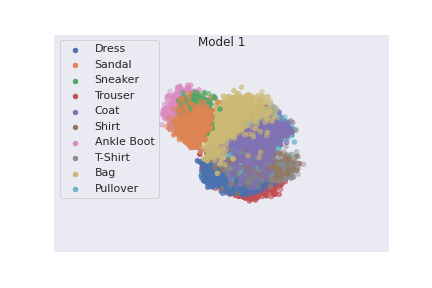

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [22]:
#Plotting codes for model 1

model.scatter_plot(test_dl)

In [23]:
#Computing code metrics for model 1

dist_1, std_1 = model.get_code_metrics(test_dl)

In [24]:
#Computing test loss for model 1

t_loss_1 = model.test_loss(test_dl)

In [28]:
#Saving model 1 and results

model.save_model('model1.pt')
model.save_results('results1.csv')

In [29]:
#Initiating model 2

model = Autoencoder(**params2)

In [30]:
#Training model 2

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0519, val_loss: 0.0379
Epoch [1], train_loss: 0.0328, val_loss: 0.0317
Epoch [2], train_loss: 0.0283, val_loss: 0.0303
Epoch [3], train_loss: 0.0268, val_loss: 0.0300
Epoch [4], train_loss: 0.0261, val_loss: 0.0296
Epoch [5], train_loss: 0.0255, val_loss: 0.0294
Epoch [6], train_loss: 0.0251, val_loss: 0.0294
Epoch [7], train_loss: 0.0247, val_loss: 0.0297
Epoch [8], train_loss: 0.0244, val_loss: 0.0280
Epoch [9], train_loss: 0.0242, val_loss: 0.0283
Epoch [10], train_loss: 0.0239, val_loss: 0.0284
Epoch [11], train_loss: 0.0238, val_loss: 0.0273
Epoch [12], train_loss: 0.0236, val_loss: 0.0270
Epoch [13], train_loss: 0.0235, val_loss: 0.0276
Epoch [14], train_loss: 0.0234, val_loss: 0.0280
Epoch [15], train_loss: 0.0233, val_loss: 0.0271
Epoch [16], train_loss: 0.0232, val_loss: 0.0270
Epoch [17], train_loss: 0.0231, val_loss: 0.0268
Epoch [18], train_loss: 0.0230, val_loss: 0.0274
Epoch [19], train_loss: 0.0229, val_loss: 0.0261
Epoch [20], train_loss: 0.0229

In [31]:
#Computing model 2 code metrics

dist_2, std_2 = model.get_code_metrics(test_dl)

In [32]:
#Computing model 2 test loss

t_loss_2 = model.test_loss(test_dl)

In [33]:
#Storing model 1 and 2 test losses

t_loss = pd.concat([t_loss_1, t_loss_2], axis=1)

In [34]:
#Storing model 1 and 2 code std's

std = pd.concat([std_1, std_2], axis=1)

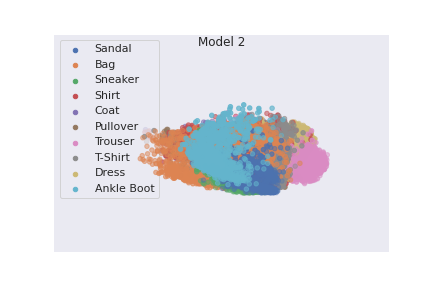

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [37]:
#Plotting model 2 codes

model.scatter_plot(test_dl)

In [38]:
#Saving model 2 and results

model.save_model('model2.pt')
model.save_results('results2.csv')

In [39]:
#Initiating model 3

model = Autoencoder(**params3)

In [40]:
#Training model 3

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0655, val_loss: 0.0530
Epoch [1], train_loss: 0.0486, val_loss: 0.0475
Epoch [2], train_loss: 0.0364, val_loss: 0.0363
Epoch [3], train_loss: 0.0325, val_loss: 0.0348
Epoch [4], train_loss: 0.0313, val_loss: 0.0326
Epoch [5], train_loss: 0.0305, val_loss: 0.0316
Epoch [6], train_loss: 0.0301, val_loss: 0.0323
Epoch [7], train_loss: 0.0298, val_loss: 0.0304
Epoch [8], train_loss: 0.0296, val_loss: 0.0311
Epoch [9], train_loss: 0.0293, val_loss: 0.0303
Epoch [10], train_loss: 0.0288, val_loss: 0.0303
Epoch [11], train_loss: 0.0292, val_loss: 0.0315
Epoch [12], train_loss: 0.0292, val_loss: 0.0293
Epoch [13], train_loss: 0.0289, val_loss: 0.0294
Epoch [14], train_loss: 0.0283, val_loss: 0.0290
Epoch [15], train_loss: 0.0280, val_loss: 0.0284
Epoch [16], train_loss: 0.0280, val_loss: 0.0308
Epoch [17], train_loss: 0.0282, val_loss: 0.0289
Epoch [18], train_loss: 0.0279, val_loss: 0.0279
Epoch [19], train_loss: 0.0277, val_loss: 0.0290
Epoch [20], train_loss: 0.0275

In [41]:
#Computing model 3 code metrics

dist_3, std_3 = model.get_code_metrics(test_dl)

In [42]:
#Computing model 3 test loss

t_loss_3 = model.test_loss(test_dl)

In [43]:
#Storing model 3 test loss

t_loss = pd.concat([t_loss, t_loss_3], axis=1)

In [44]:
#Storing model 3 code std's

std = pd.concat([std, std_3], axis=1)

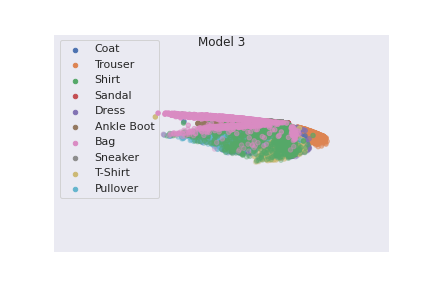

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [45]:
#Plotting model 3 codes

model.scatter_plot(test_dl)

In [46]:
#Saving model 3

model.save_model('model3.pt')
model.save_results('results3.csv')

In [47]:
#Initiating model 4

model = Autoencoder(**params4)

In [48]:
#Training model 4

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0559, val_loss: 0.0406
Epoch [1], train_loss: 0.0341, val_loss: 0.0378
Epoch [2], train_loss: 0.0319, val_loss: 0.0343
Epoch [3], train_loss: 0.0308, val_loss: 0.0332
Epoch [4], train_loss: 0.0302, val_loss: 0.0337
Epoch [5], train_loss: 0.0295, val_loss: 0.0324
Epoch [6], train_loss: 0.0292, val_loss: 0.0317
Epoch [7], train_loss: 0.0287, val_loss: 0.0296
Epoch [8], train_loss: 0.0285, val_loss: 0.0301
Epoch [9], train_loss: 0.0281, val_loss: 0.0295
Epoch [10], train_loss: 0.0279, val_loss: 0.0289
Epoch [11], train_loss: 0.0275, val_loss: 0.0281
Epoch [12], train_loss: 0.0266, val_loss: 0.0284
Epoch [13], train_loss: 0.0256, val_loss: 0.0266
Epoch [14], train_loss: 0.0248, val_loss: 0.0261
Epoch [15], train_loss: 0.0244, val_loss: 0.0259
Epoch [16], train_loss: 0.0240, val_loss: 0.0252
Epoch [17], train_loss: 0.0236, val_loss: 0.0247
Epoch [18], train_loss: 0.0233, val_loss: 0.0245
Epoch [19], train_loss: 0.0231, val_loss: 0.0244
Epoch [20], train_loss: 0.0229

In [49]:
#Computing model 4 code metrics

dist_4, std_4 = model.get_code_metrics(test_dl)

In [50]:
#Computing model 4 test loss

t_loss_4 = model.test_loss(test_dl)

In [51]:
#Storing model 4 test loss

t_loss = pd.concat([t_loss, t_loss_4], axis=1)

In [52]:
#Storing model 4 code std's

std = pd.concat([std, std_4], axis=1)

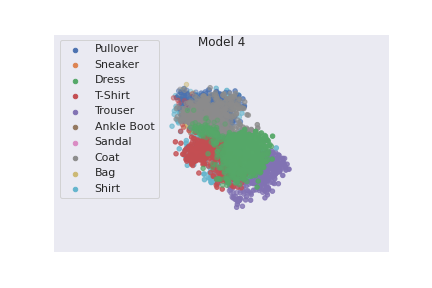

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [53]:
#Plotting model 4 codes

model.scatter_plot(test_dl)

In [54]:
#Saving model 4 and results

model.save_model('model4.pt')
model.save_results('results4.csv')

In [55]:
#Initiating model 5

model = Autoencoder(**params5)

In [56]:
#Training model 5

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0513, val_loss: 0.0354
Epoch [1], train_loss: 0.0332, val_loss: 0.0327
Epoch [2], train_loss: 0.0313, val_loss: 0.0303
Epoch [3], train_loss: 0.0284, val_loss: 0.0275
Epoch [4], train_loss: 0.0266, val_loss: 0.0264
Epoch [5], train_loss: 0.0257, val_loss: 0.0257
Epoch [6], train_loss: 0.0251, val_loss: 0.0253
Epoch [7], train_loss: 0.0247, val_loss: 0.0249
Epoch [8], train_loss: 0.0244, val_loss: 0.0247
Epoch [9], train_loss: 0.0241, val_loss: 0.0242
Epoch [10], train_loss: 0.0239, val_loss: 0.0241
Epoch [11], train_loss: 0.0237, val_loss: 0.0240
Epoch [12], train_loss: 0.0235, val_loss: 0.0237
Epoch [13], train_loss: 0.0234, val_loss: 0.0237
Epoch [14], train_loss: 0.0233, val_loss: 0.0236
Epoch [15], train_loss: 0.0232, val_loss: 0.0237
Epoch [16], train_loss: 0.0231, val_loss: 0.0235
Epoch [17], train_loss: 0.0230, val_loss: 0.0234
Epoch [18], train_loss: 0.0229, val_loss: 0.0234
Epoch [19], train_loss: 0.0229, val_loss: 0.0234
Epoch [20], train_loss: 0.0228

In [57]:
#Computing model 5 code metrics

dist_5, std_5 = model.get_code_metrics(test_dl)

In [58]:
#Computing model 5 test loss

t_loss_5 = model.test_loss(test_dl)

In [59]:
#Storing model 5 test loss

t_loss = pd.concat([t_loss, t_loss_5], axis=1)

In [60]:
#Storing model 5 code std's

std = pd.concat([std, std_5], axis=1)

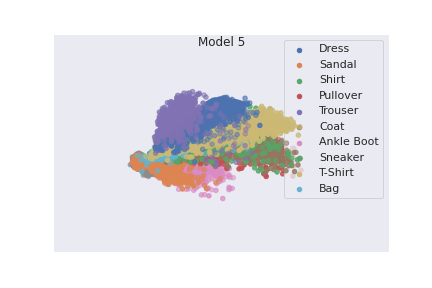

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [61]:
#Plotting model 5 codes

model.scatter_plot(test_dl)

In [62]:
#Saving model 5 and results

model.save_model('model5.pt')
model.save_results('results5.csv')

In [63]:
#Initiating model 6

model = Autoencoder(**params6)

In [64]:
#Trainig model 6

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0516, val_loss: 0.0349
Epoch [1], train_loss: 0.0299, val_loss: 0.0281
Epoch [2], train_loss: 0.0269, val_loss: 0.0264
Epoch [3], train_loss: 0.0255, val_loss: 0.0254
Epoch [4], train_loss: 0.0248, val_loss: 0.0247
Epoch [5], train_loss: 0.0242, val_loss: 0.0243
Epoch [6], train_loss: 0.0238, val_loss: 0.0239
Epoch [7], train_loss: 0.0234, val_loss: 0.0236
Epoch [8], train_loss: 0.0232, val_loss: 0.0235
Epoch [9], train_loss: 0.0230, val_loss: 0.0232
Epoch [10], train_loss: 0.0228, val_loss: 0.0233
Epoch [11], train_loss: 0.0226, val_loss: 0.0231
Epoch [12], train_loss: 0.0225, val_loss: 0.0229
Epoch [13], train_loss: 0.0224, val_loss: 0.0229
Epoch [14], train_loss: 0.0223, val_loss: 0.0229
Epoch [15], train_loss: 0.0222, val_loss: 0.0226
Epoch [16], train_loss: 0.0221, val_loss: 0.0225
Epoch [17], train_loss: 0.0220, val_loss: 0.0225
Epoch [18], train_loss: 0.0219, val_loss: 0.0224
Epoch [19], train_loss: 0.0218, val_loss: 0.0223
Epoch [20], train_loss: 0.0218

In [65]:
#Computing model 6 code metrics

dist_6, std_6 = model.get_code_metrics(test_dl)

In [66]:
#Computing model 6 test loss

t_loss_6 = model.test_loss(test_dl)

In [67]:
#Storing model 6 test loss

t_loss = pd.concat([t_loss, t_loss_6], axis=1)

In [68]:
#Storing model 6 code std's

std = pd.concat([std, std_6], axis=1)

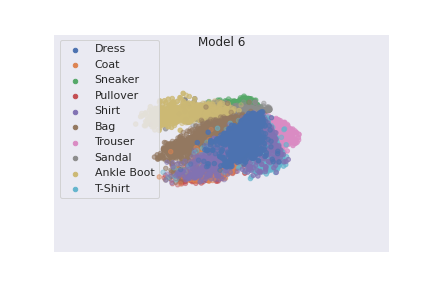

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [69]:
#Plotting model 6 codes

model.scatter_plot(test_dl)

In [70]:
#Saving model 6 and results

model.save_model('model6.pt')
model.save_results('results6.csv')

In [71]:
#Initiating model 7

model = Autoencoder(**params7)

In [72]:
#Training model 7

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0594, val_loss: 0.0395
Epoch [1], train_loss: 0.0363, val_loss: 0.0356
Epoch [2], train_loss: 0.0337, val_loss: 0.0325
Epoch [3], train_loss: 0.0318, val_loss: 0.0327
Epoch [4], train_loss: 0.0311, val_loss: 0.0303
Epoch [5], train_loss: 0.0305, val_loss: 0.0302
Epoch [6], train_loss: 0.0301, val_loss: 0.0298
Epoch [7], train_loss: 0.0298, val_loss: 0.0294
Epoch [8], train_loss: 0.0293, val_loss: 0.0296
Epoch [9], train_loss: 0.0292, val_loss: 0.0296
Epoch [10], train_loss: 0.0292, val_loss: 0.0294
Epoch [11], train_loss: 0.0289, val_loss: 0.0288
Epoch [12], train_loss: 0.0286, val_loss: 0.0288
Epoch [13], train_loss: 0.0284, val_loss: 0.0285
Epoch [14], train_loss: 0.0287, val_loss: 0.0292
Epoch [15], train_loss: 0.0288, val_loss: 0.0285
Epoch [16], train_loss: 0.0279, val_loss: 0.0281
Epoch [17], train_loss: 0.0286, val_loss: 0.0295
Epoch [18], train_loss: 0.0283, val_loss: 0.0281
Epoch [19], train_loss: 0.0285, val_loss: 0.0287
Epoch [20], train_loss: 0.0282

In [73]:
#Computing model 7 code metrics

dist_7, std_7 = model.get_code_metrics(test_dl)

In [74]:
#Computing model 7 test loss

t_loss_7 = model.test_loss(test_dl)

In [75]:
#Storing model 7 test loss

t_loss = pd.concat([t_loss, t_loss_7], axis=1)

In [76]:
#Storing model 7 code std's

std = pd.concat([std, std_7], axis=1)

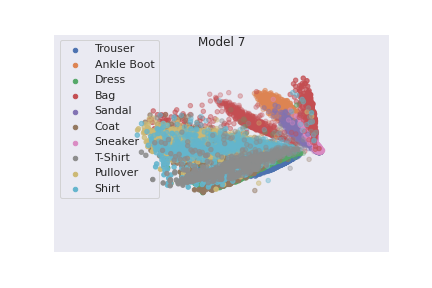

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [77]:
#Plotting model 7 codes

model.scatter_plot(test_dl)

In [78]:
#Saving model 7 and results

model.save_model('model7.pt')
model.save_results('results7.csv')

In [79]:
#Initiating model 8

model = Autoencoder(**params8)

In [80]:
#Training model 8

model.fit(train_dl, val_dl)

Epoch [0], train_loss: 0.0612, val_loss: 0.0480
Epoch [1], train_loss: 0.0469, val_loss: 0.0455
Epoch [2], train_loss: 0.0420, val_loss: 0.0392
Epoch [3], train_loss: 0.0369, val_loss: 0.0350
Epoch [4], train_loss: 0.0333, val_loss: 0.0323
Epoch [5], train_loss: 0.0314, val_loss: 0.0309
Epoch [6], train_loss: 0.0300, val_loss: 0.0300
Epoch [7], train_loss: 0.0288, val_loss: 0.0289
Epoch [8], train_loss: 0.0286, val_loss: 0.0282
Epoch [9], train_loss: 0.0277, val_loss: 0.0273
Epoch [10], train_loss: 0.0272, val_loss: 0.0274
Epoch [11], train_loss: 0.0268, val_loss: 0.0270
Epoch [12], train_loss: 0.0266, val_loss: 0.0265
Epoch [13], train_loss: 0.0264, val_loss: 0.0265
Epoch [14], train_loss: 0.0261, val_loss: 0.0263
Epoch [15], train_loss: 0.0259, val_loss: 0.0262
Epoch [16], train_loss: 0.0257, val_loss: 0.0265
Epoch [17], train_loss: 0.0258, val_loss: 0.0258
Epoch [18], train_loss: 0.0262, val_loss: 0.0263
Epoch [19], train_loss: 0.0258, val_loss: 0.0254
Epoch [20], train_loss: 0.0255

In [81]:
#Computing model 8 code metrics

dist_8, std_8 = model.get_code_metrics(test_dl)

In [82]:
#Computing model 8 train loss

t_loss_8 = model.test_loss(test_dl)

In [83]:
#Storing model 8 train loss

t_loss = pd.concat([t_loss, t_loss_8], axis=1)

In [84]:
#Storing model 8 code std's

std = pd.concat([std, std_8], axis=1)

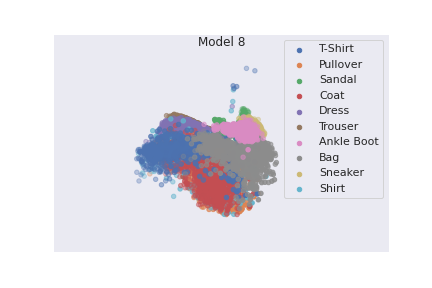

Unhandled message type set_device_pixel_ratio. {'type': 'set_device_pixel_ratio', 'device_pixel_ratio': 2.5}


In [85]:
#Plotting model 8 codes

model.scatter_plot(test_dl)

In [86]:
#Saving model 8 and results

model.save_model('model8.pt')
model.save_results('results8.csv')

In [87]:
#Adding pc std's to dataframe

std = pd.concat([std, df_pca_std], axis=1)

In [91]:
#Saving test loss df, std df, and distances df's

t_loss.to_pickle('losses.pkl')
std.to_pickle('std.pkl')
df_pca_dist.to_pickle('dist_pca.pkl')
dist_1.to_pickle('dist_1.pkl')
dist_2.to_pickle('dist_2.pkl')
dist_3.to_pickle('dist_3.pkl')
dist_4.to_pickle('dist_4.pkl')
dist_5.to_pickle('dist_5.pkl')
dist_6.to_pickle('dist_6.pkl')
dist_7.to_pickle('dist_7.pkl')
dist_8.to_pickle('dist_8.pkl')



## Autoencoder Training/Validation/Testing Results

In [92]:
#Loading train/val histories

df1 = pd.read_csv("/content/results1.csv")
df2 = pd.read_csv("/content/results2.csv")
df3 = pd.read_csv("/content/results3.csv")
df4 = pd.read_csv("/content/results4.csv")
df5 = pd.read_csv("/content/results5.csv")
df6 = pd.read_csv("/content/results6.csv")
df7 = pd.read_csv("/content/results7.csv")
df8 = pd.read_csv("/content/results8.csv")

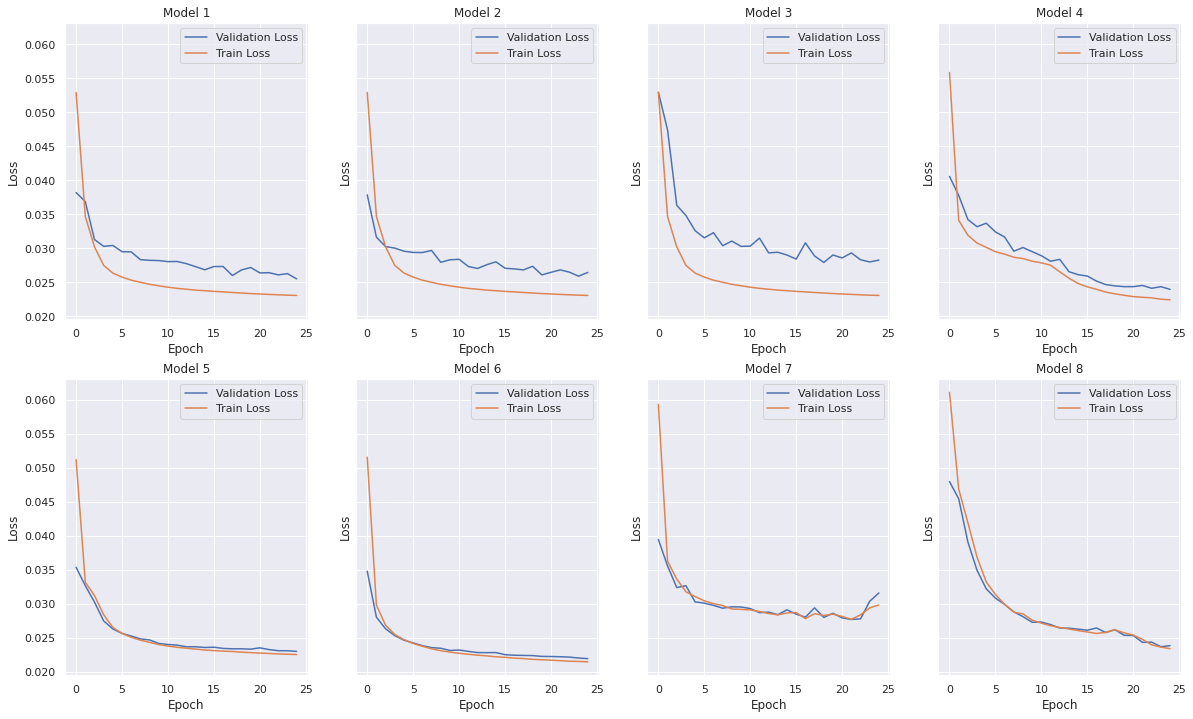

In [129]:
#Plotting validation and train loss

%matplotlib inline

fig, axs = plt.subplots(2, 4, figsize=(20,12), sharey=True)
axs[0,0].plot(range(25), df1['val_loss'], label="Validation Loss")
axs[0,0].plot(df1['train_loss'], label="Train Loss")
axs[0,0].set_title('Model 1')
axs[0,1].plot(range(25), df2['val_loss'], label="Validation Loss")
axs[0,1].plot(df1['train_loss'], label="Train Loss")
axs[0,1].set_title('Model 2')
axs[0,2].plot(range(25), df3['val_loss'], label="Validation Loss")
axs[0,2].plot(df1['train_loss'], label="Train Loss")
axs[0,2].set_title('Model 3')
axs[0,3].plot(range(25), df4['val_loss'], label="Validation Loss")
axs[0,3].plot(df4['train_loss'], label="Train Loss")
axs[0,3].set_title('Model 4')
axs[1,0].plot(range(25), df5['val_loss'], label="Validation Loss")
axs[1,0].plot(df5['train_loss'], label="Train Loss")
axs[1,0].set_title('Model 5')
axs[1,1].plot(range(25), df6['val_loss'], label="Validation Loss")
axs[1,1].plot(df6['train_loss'], label="Train Loss")
axs[1,1].set_title('Model 6')
axs[1,2].plot(range(25), df7['val_loss'], label="Validation Loss")
axs[1,2].plot(df7['train_loss'], label="Train Loss")
axs[1,2].set_title('Model 7')
axs[1,3].plot(range(25), df8['val_loss'], label="Validation Loss")
axs[1,3].plot(df8['train_loss'], label="Train Loss")
axs[1,3].set_title('Model 8')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')
    ax.legend()

plt.show()

The training and validation losses for each network are plotted above.  Recall that models 1-4 all had noise added to the training images.  It is interesting to note that the validation loss is a lot more noisy than it is in the other cases.  Clearly, adding noise made it more difficult for these networks to extrapolate from the training data to the validation data.  The odd numbered networks had weight decay.  It is not clear from these graphs that weight-decay had any effect on training.  Models 3, 4, 7, and 8 had two stacks instead of one.  It seems that these networks may not have achieved as low of a validation loss as the others.  However, perhaps these networks needed a bit more training, especially model 8.

Next, it is time to look at the codes of the test data.

In [195]:
#List for storing distance df's
dist_dfs = [dist_1, dist_2, dist_3, dist_4, dist_5, dist_6, dist_7, dist_8, df_pca_dist]


t_shirt_to_shirt = []
#Compute t-shirt to shirt distance between means
for df in dist_dfs:
    t_shirt_to_shirt.append(df['T-Shirt'].loc['Shirt'])

sandal_to_sneaker = []
#Compute sandal to sneaker distance between means
for df in dist_dfs:
    sandal_to_sneaker.append(df['Sandal'].loc['Sneaker'])

sneaker_to_dress = []
#Compute sneaker to dress distance between means
for df in dist_dfs:
    sneaker_to_dress.append(df['Sneaker'].loc['Dress'])




In [197]:
#List for storing model names - will be used for plotting

names = [params[i]['NAME'] for i in range(1,9)]
names.append('PCA')

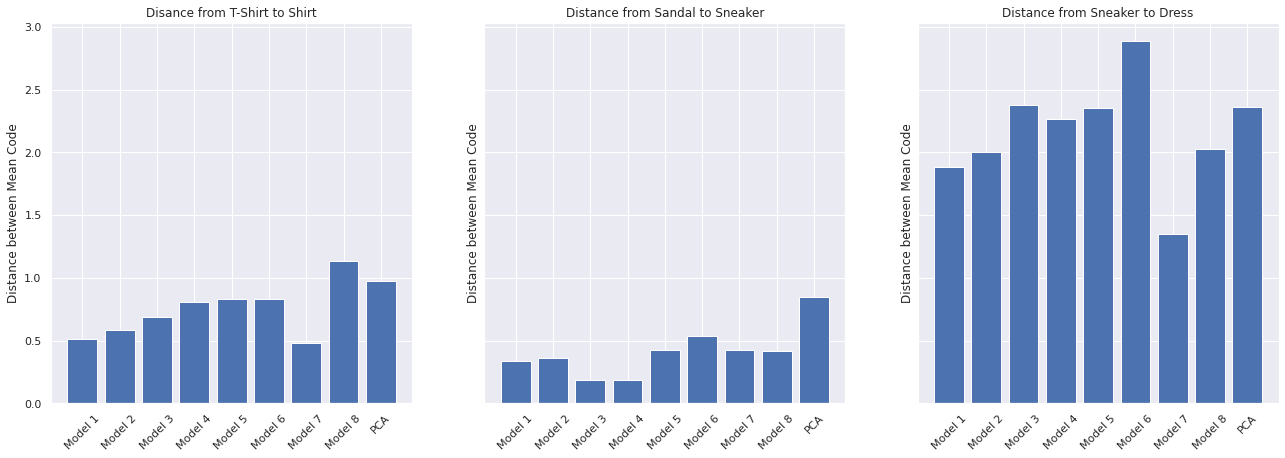

In [203]:
#Plotting distances

fig, axs = plt.subplots(1, 3, figsize=(22,7), sharey=True)
axs[0].bar(names, t_shirt_to_shirt)
axs[0].set_title('Disance from T-Shirt to Shirt')
axs[1].bar(names, sandal_to_sneaker)
axs[1].set_title('Distance from Sandal to Sneaker')
axs[2].bar(names, sneaker_to_dress)
axs[2].set_title('Distance from Sneaker to Dress')


for ax in axs.flat:
    ax.set(ylabel='Distance between Mean Code')
    ax.set_xticklabels(names, rotation=45)


Above for each model, including PCA, are graphs displaying distances between the mean codes (or PC) for a few illustrative examples.  As expected, in each case the distance between two disimilar items (sneaker and dress) is much greater than the distance between two similar items (sandal and sneaker or t-shirt and shirt).  On average, every model is coding "sandals" and "sneakers" closer together.  The same is true for the first graph, except for model 8.  This may be an indication that the codes of the autoencoders are better representations of these categories than the PC's, as similar items are closer together for the codes than they are for the PC's.  However, we do have to be concerned about the possibility of similar items being mapped too close together.  For example, although it is true that sandals and sneakers are both similar in the sense that both are examples of footwear, perhaps models 3 and 4 are mapping these two articles of clothing too close together.  In the third graph, only model 6 maps "sneakers" and "dress" farther apart compared to PCA.  As the "sneakers" and "dress" categories are perhaps the most differing categories in the dataset, we'd expect the means of the representations to be as far apart as possible, so the fact that model 6 mapped them farther apart than the other models may be an indication that the codes of model 6 are better for this category.  There does not seem to be any major pattern when it comes to the hyperparameters that I experimented with.  It seems that the models that had noise during training (models 1-4) and models with weight decay (the odd numbered models) tended to map things across the board slightly closer together.  Note that model 6 had no weight decay, no noise added to the training images, and had only 1 stack. 

In [144]:
t_loss

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Ankle Boot,0.024449,0.024569,0.028574,0.025946,0.023025,0.022196,0.030359,0.023481
Bag,0.032782,0.033835,0.040132,0.032458,0.031520,0.029981,0.042345,0.031369
Coat,0.024314,0.028060,0.028126,0.022289,0.022256,0.021574,0.033514,0.023406
Dress,0.025843,0.024977,0.027972,0.022477,0.021657,0.021115,0.030218,0.023379
Pullover,0.025408,0.027435,0.027918,0.023108,0.023176,0.022212,0.034729,0.023869
Sandal,0.034082,0.035672,0.034643,0.033011,0.029611,0.029117,0.033321,0.030158
Shirt,0.025190,0.026543,0.027940,0.022527,0.023150,0.022099,0.031877,0.023832
Sneaker,0.018810,0.021455,0.019794,0.019710,0.016459,0.015167,0.020091,0.016983
T-Shirt,0.025104,0.024344,0.027396,0.022608,0.022498,0.020904,0.033949,0.023586
Trouser,0.017038,0.017620,0.019240,0.015222,0.013785,0.013312,0.022675,0.017684


In [145]:
std

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,PCA
Ankle Boot,0.289668,0.376187,0.215642,0.133085,0.314343,0.506096,0.271770,0.222402,0.368222
Bag,0.392801,0.544793,0.763375,0.384419,0.459039,0.709627,0.574597,0.538433,0.486946
Coat,0.344041,0.442344,0.528192,0.510099,0.516180,0.570263,0.430389,0.606179,0.550416
Dress,0.366600,0.362217,0.427756,0.628972,0.450772,0.542652,0.243854,0.456755,0.482163
Pullover,0.330933,0.417223,0.531935,0.434148,0.484305,0.521507,0.419903,0.595109,0.424838
Sandal,0.247338,0.274572,0.137714,0.102555,0.280699,0.373284,0.229545,0.273157,0.312268
Shirt,0.420298,0.505113,0.673571,0.586628,0.571477,0.690195,0.459825,0.707454,0.571689
Sneaker,0.240498,0.231210,0.094346,0.071448,0.209817,0.252301,0.183266,0.189021,0.264400
T-Shirt,0.402740,0.413054,0.600031,0.531680,0.557191,0.569829,0.321511,0.645730,0.448952
Trouser,0.261100,0.296798,0.288299,0.449366,0.367531,0.397193,0.185937,0.362667,0.369599


The first table above displays the testing loss (reconstruction loss) for each category and each model.  It seems that for each category, each model performed rougly similarly.  It appears that trousers and sneakers are the easiest categories to reconstruct, while bags and sandals are the hardest.    The second table displays the standard deviation of the codes (or PC's) for each model.  It is interesting to see that these widely vary across the different models.  Sometimes they are higher and sometimes lower than for PCA.  In the case of the "shirt" category, there is almost a .30 difference between the models with the highest and the lowest standard deviation.  This may indicate that each network finds sometimes dramatically different ways of representing images in three dimensions.  In particular, notice how the scatter plots of the codes that were generated during training are wildly different for each model.  While there is always a significant amount of clustering for each category, the distribution in space can be very different between models.  For example, in some plots, the codes are all clustered into a ball-like shape, while in others, the codes are spread out like a fan.  In a few, the overall clustering is almost flat like a disk.

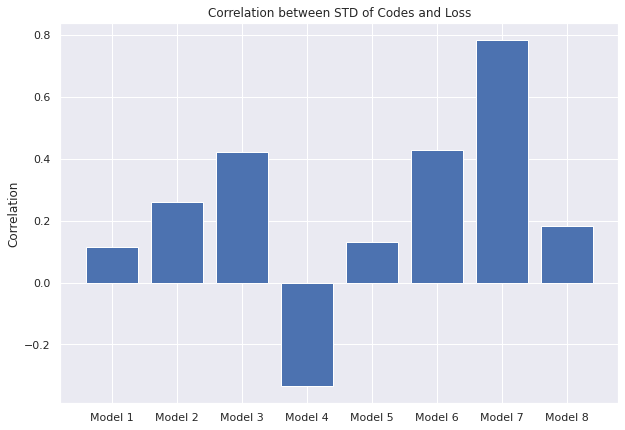

In [166]:
#Computing correlation between std's and test loss
corrs = []
for i in range(8):
    name = 'Model ' + str(i+1)
    t_1 = t_loss[name].to_numpy()
    st = std[name][:-1].to_numpy()
    corrs.append(np.corrcoef(t_1[:-1], st)[0,1])

names = [params[i]['NAME'] for i in range(1,9)]

#Plotting
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)
plt.bar(names, corrs)
plt.title('Correlation between STD of Codes and Loss')
plt.ylabel('Correlation')
plt.show()



Above is a bar plot showing the correlation between the standard deviation of each category of the codes and the test loss of each category.  It is clear that the results are very different between the models suggesting that a tight or loose clustering of the latent representations of a category does not necessarily indicate anything about the test loss.  This may further indicate that the autoencoders find more nuanced ways of distributing the codes in space.

## Logistic Regression

To further test the quality of the latent representations of the autoencoders, I now use these representations as features in a logistic model for classifying the images.  I will compare these results to a logistic classifier trained with the PC's from the PCA computed at the beginning of the report.

In [98]:
from sklearn.linear_model import LogisticRegression

#We will use the test datset - but we must split into train/test for classifier
lr_train, lr_test = random_split(test_data, [9000,1000])

#Creating dataloaders
train_dl_lr = DataLoader(lr_train, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dl_lr = DataLoader(lr_test, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

accuracies = []

for i in range(1,9):
    #Initializing and loading models
    model = Autoencoder(**params[i])
    filename = '/content/model' + str(i) + '.pt'
    model.load_state_dict(torch.load(filename))
    #Getting codes and labels
    train_codes, train_labels = model.get_codes(train_dl_lr)
    test_codes, test_labels = model.get_codes(test_dl_lr)
    train_codes = train_codes.numpy()
    train_labels = train_labels.numpy()
    test_codes = test_codes.numpy()
    test_labels = test_labels.numpy()
    #Fit classifier
    clf = LogisticRegression(max_iter=300).fit(train_codes, train_labels)
    #Get accuracy
    acc = clf.score(test_codes, test_labels)
    accuracies.append(acc)

In [223]:
#In this cell, we train a logistic classifier on the pc's

#Getting labels - Recall, we made these when doing PCA above
train_pca_labels = np.array(pca_labels[:9000])
test_pca_labels = np.array(pca_labels[9000:])
train_components = components[:9000,:]
#Getting components
test_components = components[9000:,:]
#Train classifier
clf = LogisticRegression(max_iter=300).fit(train_components, train_pca_labels)
#Get accuracy
acc = clf.score(test_components, test_pca_labels)
#Add result to accuracies list
accuracies.append(acc)

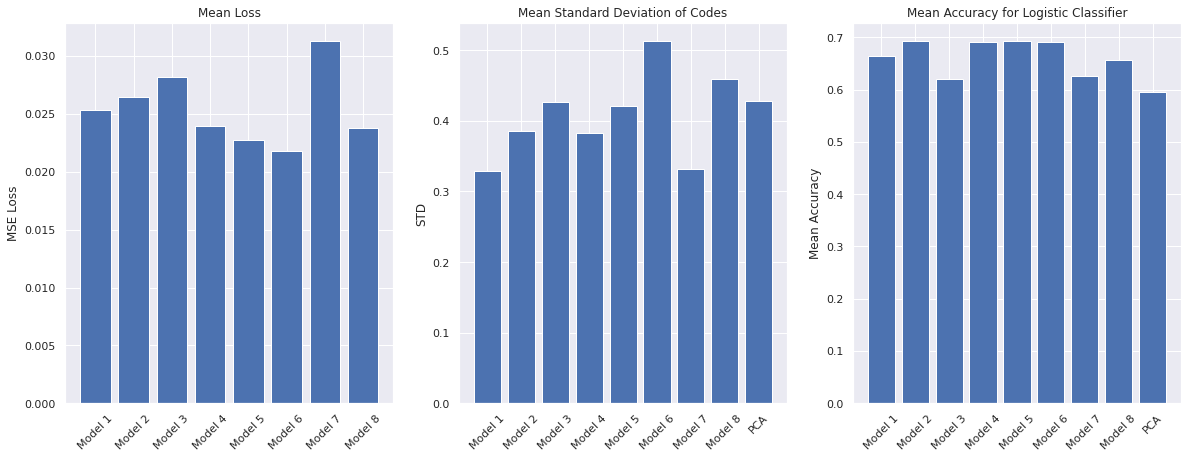

In [241]:
#Plotting mean loss, mean std, and mean accuracy for logistic classifier

#Get mean loss (i.e., average over classes) for each model
t_loss_list = list(t_loss.mean())
#Get mean std (i.e., average over classes) for each model
std_list = list(std.mean())
#Model names for plotting
names = [params[i]['NAME'] for i in range(1,9)]


fig, axs = plt.subplots(1, 3, figsize=(20,7))
axs[0].bar(range(8), t_loss_list)
axs[0].set_title('Mean Loss')
axs[0].set(ylabel='MSE Loss')
axs[0].set_xticks([0,1,2,3,4,5,6,7])
axs[0].set_xticklabels(names, rotation=45)
axs[1].bar(range(9), std_list[:-1]+[df_pca_std.mean()[0]])
axs[1].set_title('Mean Standard Deviation of Codes')
axs[1].set_xticks([0,1,2,3,4,5,6,7,8])
axs[1].set_xticklabels(names + ['PCA'], rotation=45)
axs[1].set(ylabel='STD')
axs[2].bar(range(9), accuracies)
axs[2].set_title('Mean Accuracy for Logistic Classifier')
axs[2].set(ylabel='Mean Accuracy')
axs[2].set_xticks([0,1,2,3,4,5,6,7,8])
axs[2].set_xticklabels(names + ['PCA'], rotation=45)

fig.show()

Above are bar graphs of the mean loss (averaged over the classes), the standard deviation of the codes (averaged over all the classes) and the mean accuracy of the logistic classifiers.  It is clear that all the autoencoders beat PCA in terms of accuracy.  This indicates that the codes from the autoencoders are better at discriminating between the classes.  There is also a loose association between mean loss and accuracy.  The lower the mean reconstruction loss is, the higher the accuracy tends to be, which suggests that perhaps the reconstruction loss is somewhat indicative of how well the latent space representations capture the data.  There is no apparent relationship between the standard deviation of codes and accuracy, which further suggests that each network finds a unique way of distributing codes in space.  Again, in terms of accuracy, we see that the models without weight decay tend to outperform those with weight decay.  In addition, the models with 2 stacks (3, 4, 7, and 8) performed slightly worse than the single-stacked models.

## Visualization

Before concluding this part of the report, I now look at a few of the images created by the autoencoders.

In [130]:
def display_images(idx):
    """
    For index in train dataset, plots original image and output of each model
    alongside its MSE loss
    """
    #Get image
    img = test_data[idx][0].squeeze()
    #Vectorize
    img_t = test_data[idx][0].view(test_data[3][0].size(0), -1)
    #Defining loss function
    loss_func = nn.MSELoss()
    imgs = [img]
    loss = ['N/A']
    title = ['Original']
    for i in range(1,9):
        #Loading model
        model = Autoencoder(**params[i])
        filename = '/content/model' + str(i) + '.pt'
        model.load_state_dict(torch.load(filename))
        #Push through network
        out = model(img_t).view((28,28)).detach()
        #Get loss
        ls = loss_func(img, im)
        imgs.append(out)
        loss.append(round(ls.item(),4))
        title.append(params[i]['NAME'])

    fig = plt.figure(figsize=(20, 25))
    counter = 1
    for i in range(9):
        a = fig.add_subplot(5, 5, counter)
        counter += 1
        imgplot = plt.imshow(imgs[i])
        a.set_title(title[i])
        a.set_xlabel('Loss: ' + str(loss[i]))
    

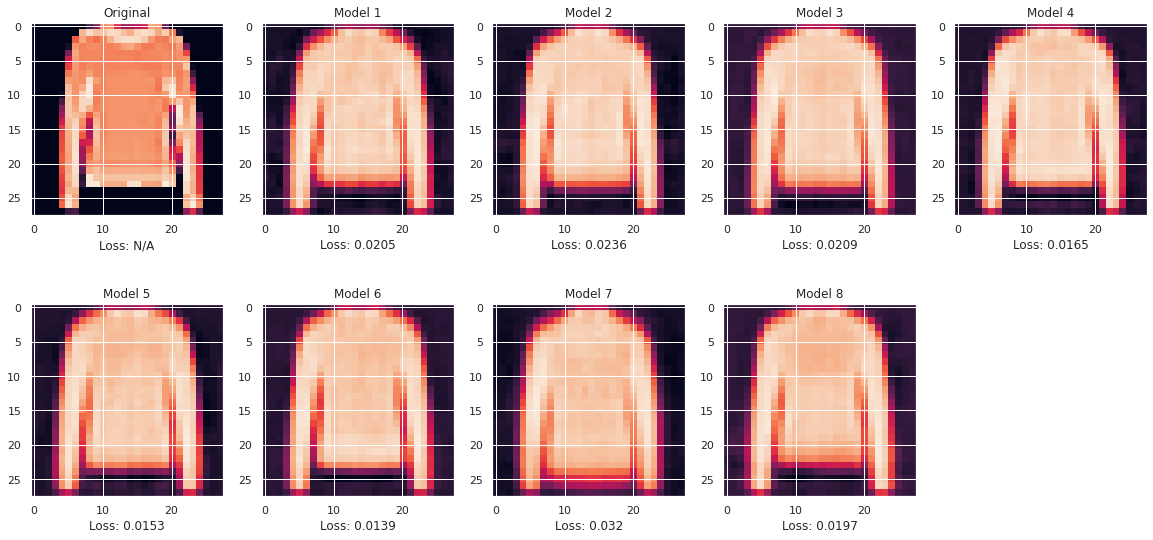

In [131]:
display_images(99)

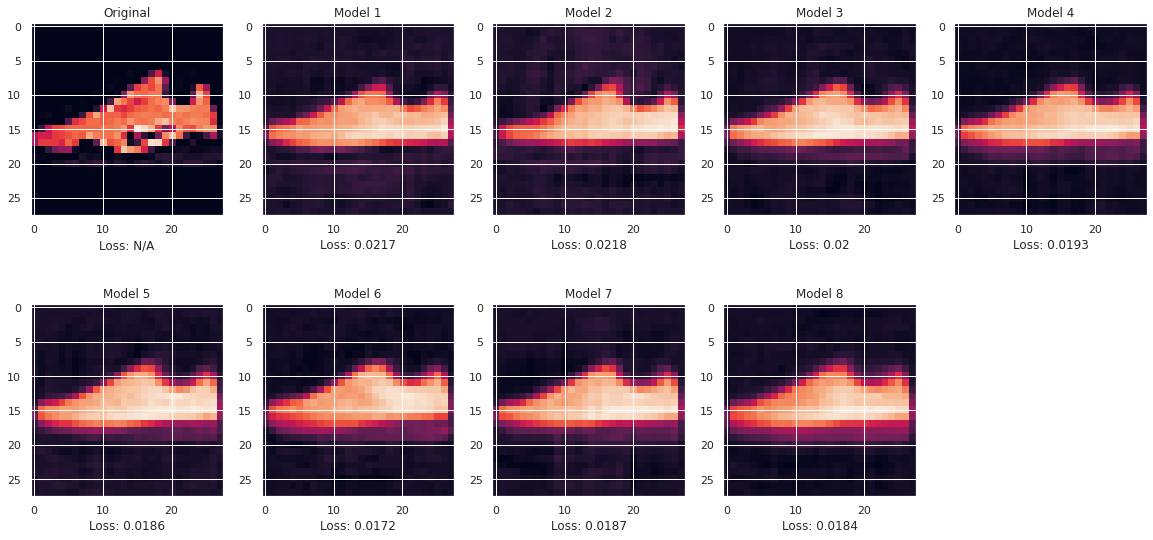

In [132]:
display_images(999)

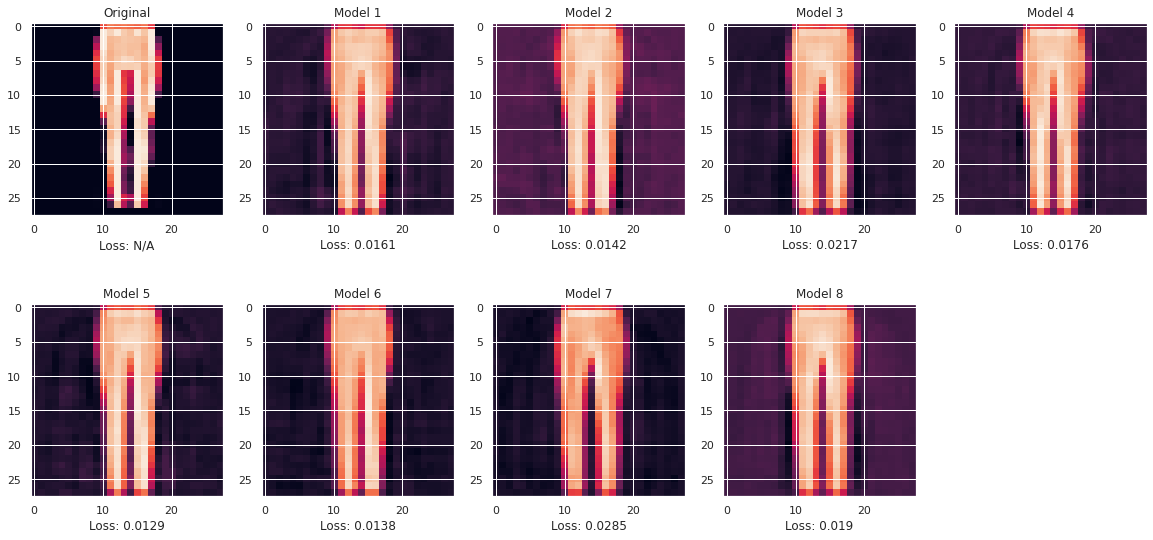

In [242]:
display_images(777)

We can see in these examples that each model is very good at capturing the overall shape of each article of clothing.  However, some of the details (such as shading) are not adequately reconstructed by any of the networks.  Overall, the images from each model look remarkably the same with only minor differences.

## Conclusion

In conclusion, it seems to be the case that the codes of the autoencoders do a better job than the PC's of the PCA at capturing an image, at least in terms of classification accuracy.  The geometry of the codes of the models were widely varying.  For each category, the models found different ways to distribute the codes in space, as the stanard deviations were different across the models.  However, the models did map the codes of similar items closer together and disimilar items farther apart.  As indicated by the scatter plots, each model clustered the codes of a category sometimes looser and sometimes tighter.  There is some indication that the autoencoders have a more nuanced way of distributing the codes in 3D space.  Perhaps this is to be expected, considering that neural networks are good at modeling non-linear relationships.  Therefore, measuring Euclidean distances may not be sufficient for characterizing the geometry of the distribution of codes.

Concerning the hyperparameters of the autoencoders, the results indicate that having 1 stack with no weight decay and no added noise is superior.

